In [1]:
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-otgm16ka
  Running command git clone --filter=blob:none -q 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pip-req-build-otgm16ka
  Resolved https://****@github.com/SKTBrain/KoBERT.git to commit 5c46b1c68e4755b54879431bd302db621f4d2f47
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 129 kB 4.9 MB/s            
     |████████████████████████████████| 344 kB 56.2 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 54.7 MB 21 kB/s              
     |████████████████████████████████| 4.5 MB 55.2 MB/s            
     |████████████████████████████████| 2.5 MB 57.8 MB/s            
     |████████████████████████████████| 73 kB 3.2 MB/s             
     |████████████████████████████████| 6.7 MB 51.0 MB/s            
     |████████████████████████████████| 127 kB 41.9 MB/s            
  Created wheel for kobert: fil

In [139]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model
from sklearn.model_selection import train_test_split
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup
from sklearn.metrics import f1_score, precision_score, recall_score

In [192]:
filepath_train = os.getenv('HOME')+'/aiffel/dktc/data/train.csv'

train = pd.read_csv(filepath_train)

train.head()

,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


In [193]:
len(train)

3950

In [194]:
train.isnull().sum()

idx             0
class           0
conversation    0
dtype: int64

In [195]:
train['class'].drop_duplicates()

0          협박 대화
2      기타 괴롭힘 대화
3          갈취 대화
5    직장 내 괴롭힘 대화
Name: class, dtype: object

In [196]:
# 텍스트 클렌징 함수
def clean_text(text):
    # 불필요한 특수 문자, 숫자 제거 (한글, 영문, 공백 제외)
    text = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z\s]", "", text)
    text = re.sub(r"\n", " ", text)
    return text

train['conversation'] = train['conversation'].apply(clean_text)

In [197]:
max_length = train['conversation'].apply(len).max()
mean_length = train['conversation'].apply(len).mean()
print("최대 길이:", max_length)
print("평균 길이:", mean_length)

최대 길이: 839
평균 길이: 214.31645569620252


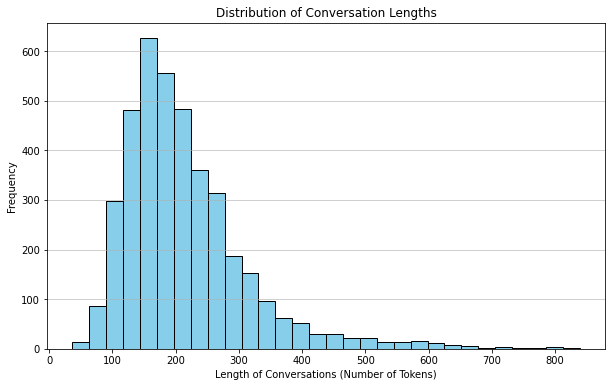

In [198]:
train['length'] = train['conversation'].apply(len)

# 히스토그램 그리기
plt.figure(figsize=(10, 6))
plt.hist(train['length'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Conversation Lengths')
plt.xlabel('Length of Conversations (Number of Tokens)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [199]:
df_over_text = train[train['length'] > 300]
df_over_text

,idx,class,conversation,length
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요 저희 회사에서 이 선크림 파는데 한 번 손등에 발...,438
5,5,직장 내 괴롭힘 대화,나 이틀뒤에 가나다 음식점 예약좀 해줘 저녁시로 가나다 음식점이요 응 남자친구 부모...,317
7,7,기타 괴롭힘 대화,경비아저씨 내차에 경고장 붙였어요 내가 여기 몇년째 사는데 아직도 내차인줄 모르고 ...,352
12,12,협박 대화,네네 무슨 일 때문에 전화주셨나요 우리 애가 지우개 하나 훔친거 가지고 애들 앞에서...,387
20,20,협박 대화,너가 민수라는 남자 제자니 네 맞는데요 왜 그러시죠 혹시 저희 선생님께 무슨 일 생...,304
...,...,...,...,...
3922,3922,갈취 대화,잘 생각해봐 이건 윈윈이야 당신은 가정 지키고 난 돈 벌 수 있고 이봐 이렇게 까지...,322
3934,3934,갈취 대화,야 돈 좀 내놔 싫어 내가 돈이 어딨어 죽고싶냐 빨리 내놔너 엄마한테 용돈 만원 받...,313
3938,3938,협박 대화,한국지검검사 윤동철 입니다 지금 박세미님 계좌가 범죄에 연루되어 있으니 빨리 저한테...,505
3941,3941,갈취 대화,동생아 내가 정말 급해서 그러는데 백만원만 빌려줄수있니 또 무슨일인데 그래 지난번에...,317


In [200]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [201]:
#bert 모델, vocab 불러오기
bertmodel, vocab = get_pytorch_kobert_model()

using cached model. /aiffel/aiffel/dktc/.cache/kobert_v1.zip
using cached model. /aiffel/aiffel/dktc/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [202]:
train.loc[(train['class'] == "협박 대화"), 'label'] = 0  # 협박 대화 => 0
train.loc[(train['class'] == "갈취 대화"), 'label'] = 1  # 갈취 대화 => 1
train.loc[(train['class'] == "직장 내 괴롭힘 대화"), 'label'] = 2  # 직장 내 괴롭힘 대화 => 2
train.loc[(train['class'] == "기타 괴롭힘 대화"), 'label'] = 3  # 기타 괴롭힘 대화 => 3
train.loc[(train['class'] == "일반 대화"), 'label'] = 4  # 일반 대화 => 4

data_list = []
for content, label in zip(train['conversation'], train['label'])  :
    temp = []
    temp.append(content)
    temp.append(str(int(label)))

    data_list.append(temp)

In [203]:
# train.drop(columns = 'idx', inplace = True)

In [204]:
data_list[0]

['지금 너 스스로를 죽여달라고 애원하는 것인가  아닙니다 죄송합니다  죽을 거면 혼자 죽지 우리까지 사건에 휘말리게 해 진짜 죽여버리고 싶게  정말 잘못했습니다  너가 선택해 너가 죽을래 네 가족을 죽여줄까  죄송합니다 정말 잘못했습니다  너에게는 선택권이 없어 선택 못한다면 너와 네 가족까지 모조리 죽여버릴거야  선택 못하겠습니다 한번만 도와주세요  그냥 다 죽여버려야겠군 이의 없지  제발 도와주세요',
 '0']

In [205]:
dataset_train, dataset_val = train_test_split(data_list, test_size = 0.2, random_state = 42)

In [206]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len, pad, pair):
        self.original_lengths = []  # 토큰화된 문장의 원래 길이를 저장할 리스트
        self.sentences = []

        # transform을 정의
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        for i in dataset:
            # 먼저 토큰화를 수행하여 문장의 길이를 확인
            tokenized_sentence = bert_tokenizer(i[sent_idx])  # 문자열로 토큰화
            self.original_lengths.append(len(tokenized_sentence))  # 토큰화된 길이를 저장

            # transform을 적용하여 max_len에 맞춰 자르기
            self.sentences.append(transform([i[sent_idx]]))  # transform 후 저장

        # 레이블 처리
        if label_idx is not None:
            self.labels = [np.int32(i[label_idx]) for i in dataset]
        else:
            self.labels = None

    def __getitem__(self, i):
        if self.labels is not None:
            return self.sentences[i] + (self.labels[i], )
        else:
            return self.sentences[i]

    def __len__(self):
        return len(self.sentences)

In [207]:
# 데이터셋을 생성
data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)

# 각 문장의 토큰화된 길이 확인
for i, length in enumerate(data_train.original_lengths):
    print(f"Train 데이터 문장 {i+1}의 토큰화된 길이: {length}")

Train 데이터 문장 1의 토큰화된 길이: 114
Train 데이터 문장 2의 토큰화된 길이: 94
Train 데이터 문장 3의 토큰화된 길이: 148
Train 데이터 문장 4의 토큰화된 길이: 73
Train 데이터 문장 5의 토큰화된 길이: 94
Train 데이터 문장 6의 토큰화된 길이: 86
Train 데이터 문장 7의 토큰화된 길이: 154
Train 데이터 문장 8의 토큰화된 길이: 111
Train 데이터 문장 9의 토큰화된 길이: 216
Train 데이터 문장 10의 토큰화된 길이: 111
Train 데이터 문장 11의 토큰화된 길이: 97
Train 데이터 문장 12의 토큰화된 길이: 150
Train 데이터 문장 13의 토큰화된 길이: 26
Train 데이터 문장 14의 토큰화된 길이: 140
Train 데이터 문장 15의 토큰화된 길이: 170
Train 데이터 문장 16의 토큰화된 길이: 214
Train 데이터 문장 17의 토큰화된 길이: 152
Train 데이터 문장 18의 토큰화된 길이: 159
Train 데이터 문장 19의 토큰화된 길이: 77
Train 데이터 문장 20의 토큰화된 길이: 73
Train 데이터 문장 21의 토큰화된 길이: 115
Train 데이터 문장 22의 토큰화된 길이: 130
Train 데이터 문장 23의 토큰화된 길이: 123
Train 데이터 문장 24의 토큰화된 길이: 76
Train 데이터 문장 25의 토큰화된 길이: 133
Train 데이터 문장 26의 토큰화된 길이: 113
Train 데이터 문장 27의 토큰화된 길이: 161
Train 데이터 문장 28의 토큰화된 길이: 74
Train 데이터 문장 29의 토큰화된 길이: 113
Train 데이터 문장 30의 토큰화된 길이: 80
Train 데이터 문장 31의 토큰화된 길이: 78
Train 데이터 문장 32의 토큰화된 길이: 126
Train 데이터 문장 33의 토큰화된 길이: 134
Train 데이터 문장 34의 토큰화된 길이: 109
T

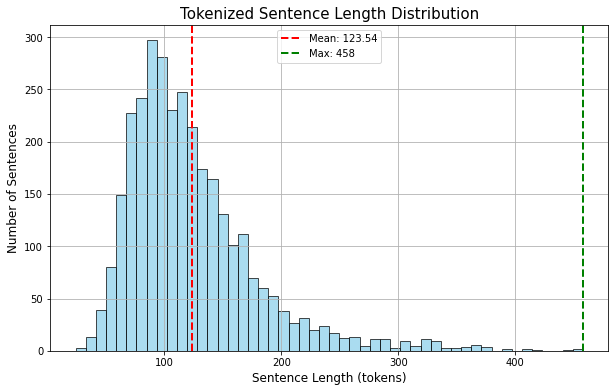

In [208]:
# 문장 길이 계산
lengths = data_train.original_lengths

# 평균 및 최댓값 계산
mean_length = np.mean(lengths)
max_length = np.max(lengths)

# 토큰화된 문장 길이 분포 시각화
plt.figure(figsize=(10, 6))
plt.hist(lengths, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(mean_length, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_length:.2f}')
plt.axvline(max_length, color='green', linestyle='dashed', linewidth=2, label=f'Max: {max_length}')

plt.title('Tokenized Sentence Length Distribution', fontsize=15)
plt.xlabel('Sentence Length (tokens)', fontsize=12)
plt.ylabel('Number of Sentences', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

In [213]:
# 토큰화 후 각 문장의 길이를 확인한 리스트 생성
tokenized_data_with_lengths = [(i[0], len(tok(i[0]))) for i in dataset_train]

# 길이 130을 초과하는 문장만 필터링
long_sentences = [(sentence, length) for sentence, length in tokenized_data_with_lengths if length > 130]

# 데이터프레임으로 변환
df_long_sentences = pd.DataFrame(long_sentences, columns=['conversation', 'Length'])

df_long_sentences

,conversation,Length
0,학부모님 안녕하세요 선생님 우리 애 성적이 왜 이래요 개똥이가 이번에 성적이 많...,148
1,원영 학생 지금 교수실로 와 예 교수님 저 지금 스케줄 없습니다 지금 우리 아들 유...,154
2,내가 맘만 먹으면 너같은 거 여기 발도 못붙이게 할 수있는거 알지 제가 뭘 잘못했다...,216
3,아니 끼어든 것은 아저씨잖아요 참나 눈을 감고 운전하셨나 눈을 감기는 직전차선에...,150
4,너 손에 그거 대체 뭐야 내가 오늘만을 기다렸다 계속 기다렸어 내가 분명 그 일은 ...,140
...,...,...
1087,이거 허니 버터칩 아니야 대박 이걸 구한 사람이 있다니 이거 맛있다 너도 사봐 난 ...,157
1088,김마리씨 내일까지 제출하라는 서류 오늘 밤까지 부탁해요 과장님 저 오늘 엄마 생신이...,185
1089,정한씨 내일 나랑 거래처 가기로 한 거 혼자 갈 수 있지 네 갑자기요 브리핑 준비...,155
1090,중요한 전화 올 수도 있으니까 점심시간에 사무실 대기 좀 해줘요 그러면 제 점심은 ...,132


In [ ]:
# df_long_sentences.to_csv('./aftertoken.csv', index=False)

In [125]:
# class BERTDataset(Dataset):
#     def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len, pad, pair):
#         transform = nlp.data.BERTSentenceTransform(
#             bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

#         self.sentences = [transform([i[sent_idx]]) for i in dataset]
        
#         # 레이블이 없는 경우를 처리
#         if label_idx is not None:
#             self.labels = [np.int32(i[label_idx]) for i in dataset]
#         else:
#             self.labels = None

#     def __getitem__(self, i):
#         if self.labels is not None:
#             return self.sentences[i] + (self.labels[i], )
#         else:
#             return self.sentences[i]

#     def __len__(self):
#         return len(self.sentences)

In [126]:
## Setting hyper-parameters
max_len = 130
batch_size = 32
warmup_ratio = 0.2
num_epochs = 25
max_grad_norm = 1
log_interval = 5
learning_rate =  5e-5
dr_rate = 0.2

In [127]:
#토큰화
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)
#BERTDataset 클래스 이용, TensorDataset으로 만들어주기
data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)
data_val = BERTDataset(dataset_val, 0, 1, tok, max_len, True, False)

using cached model. /aiffel/aiffel/dktc/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [128]:
#배치 및 데이터로더 설정
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=4)
val_dataloader = torch.utils.data.DataLoader(data_val, batch_size=batch_size, num_workers=4)

In [129]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size=768,
                 num_classes=5,
                 dr_rate=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
        self.classifier = nn.Linear(hidden_size, num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)

    def forward(self, token_ids, segment_ids):
        # attention mask는 token_ids에서 패딩(0)이 아닌 부분을 1로 설정
        attention_mask = (token_ids != 0).float()
        
        # BERT 모델에서 pooler 출력 사용
        _, pooler = self.bert(input_ids=token_ids, token_type_ids=segment_ids.long(), attention_mask=attention_mask.float().to(token_ids.device))
        
        # 드롭아웃 적용
        if self.dr_rate:
            out = self.dropout(pooler)
        
        return self.classifier(out)

In [130]:
model = BERTClassifier(bertmodel, dr_rate = dr_rate).to(device)

In [131]:
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

In [132]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [133]:
# 성능 지표 계산 함수
def calc_metrics(X, Y):
    max_vals, max_indices = torch.max(X, 1)
    pred_labels = max_indices.cpu().numpy()
    true_labels = Y.cpu().numpy()
    
    accuracy = (pred_labels == true_labels).sum() / len(true_labels)
    f1 = f1_score(true_labels, pred_labels, average='weighted')
    precision = precision_score(true_labels, pred_labels, average='weighted')
    recall = recall_score(true_labels, pred_labels, average='weighted')
    
    return accuracy, f1, precision, recall

In [136]:
# 로스와 성능 지표 저장 리스트
train_losses = []
val_losses = []
train_accs, val_accs = [], []
train_f1s, val_f1s = [], []
train_precisions, val_precisions = [], []
train_recalls = []  
val_recalls = []    

for e in range(num_epochs):
    # 각 에포크 시작 시 성능 지표 초기화
    train_acc = 0.0
    train_f1, train_precision, train_recall = 0.0, 0.0, 0.0  # 성능 지표 초기화
    test_acc, val_f1, val_precision, val_recall = 0.0, 0.0, 0.0, 0.0  # Validation 성능 지표 초기화
    train_loss = 0.0  # 훈련 로스 초기화
    val_loss = 0.0  # Validation 로스 초기화
    
    model.train()
    
    for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        label = label.long().to(device)
        
        out = model(token_ids, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        
        # 성능 지표 계산
        batch_acc, batch_f1, batch_precision, batch_recall = calc_metrics(out, label)
        train_acc += batch_acc
        train_f1 += batch_f1
        train_precision += batch_precision
        train_recall += batch_recall
        train_loss += loss.item()  # 배치의 로스를 누적
        
        if batch_id % log_interval == 0:
            print(f"Epoch {e+1} Batch {batch_id+1}: Loss {loss.data.cpu().numpy()}, Accuracy {train_acc/(batch_id+1)}, F1 {train_f1/(batch_id+1)}, Precision {train_precision/(batch_id+1)}, Recall {train_recall/(batch_id+1)}")
    
    # 에포크가 끝난 후 평균 성능 지표 계산
    train_acc /= len(train_dataloader)
    train_f1 /= len(train_dataloader)
    train_precision /= len(train_dataloader)
    train_recall /= len(train_dataloader)
    train_loss /= len(train_dataloader)
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    train_f1s.append(train_f1)
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)

    print(f"Epoch {e+1}: Train Accuracy {train_acc}, F1 {train_f1}, Precision {train_precision}, Recall {train_recall}")
    
    # Validation 성능 계산
    model.eval()
    with torch.no_grad():
        for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(val_dataloader)):
            token_ids = token_ids.long().to(device)
            segment_ids = segment_ids.long().to(device)
            label = label.long().to(device)
            
            out = model(token_ids, segment_ids)
            loss = loss_fn(out, label)
            val_loss += loss.item()  # 배치의 validation 로스를 누적
            batch_acc, batch_f1, batch_precision, batch_recall = calc_metrics(out, label)
            test_acc += batch_acc
            val_f1 += batch_f1
            val_precision += batch_precision
            val_recall += batch_recall
        
        # 에포크가 끝난 후 평균 validation 성능 지표 계산
        test_acc /= len(val_dataloader)
        val_f1 /= len(val_dataloader)
        val_precision /= len(val_dataloader)
        val_recall /= len(val_dataloader)
        val_loss /= len(val_dataloader)

        val_losses.append(val_loss)
        val_accs.append(test_acc)
        val_f1s.append(val_f1)
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)

        print(f"Epoch {e+1}: Validation Accuracy {test_acc}, F1 {val_f1}, Precision {val_precision}, Recall {val_recall}")

/tmp/ipykernel_31/3821735571.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/99 [00:00<?, ?it/s]

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1 Batch 1: Loss 1.589824914932251, Accuracy 0.28125, F1 0.24150027603974972, Precision 0.23937908496732027, Recall 0.28125


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1 Batch 6: Loss 1.6633347272872925, Accuracy 0.25, F1 0.21405788777499302, Precision 0.227322196118152, Recall 0.25
Epoch 1 Batch 11: Loss 1.5661797523498535, Accuracy 0.2869318181818182, F1 0.25784192639468795, Precision 0.299503511936667, Recall 0.2869318181818182
Epoch 1 Batch 16: Loss 1.4736438989639282, Accuracy 0.296875, F1 0.2778334944164616, Precision 0.3482603174756208, Recall 0.296875


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1 Batch 21: Loss 1.4415019750595093, Accuracy 0.3125, F1 0.2891988021240013, Precision 0.3574361652683607, Recall 0.3125
Epoch 1 Batch 26: Loss 1.5010387897491455, Accuracy 0.3161057692307692, F1 0.2923642174049617, Precision 0.36027761926445956, Recall 0.3161057692307692


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Pr

Epoch 1 Batch 31: Loss 1.4012761116027832, Accuracy 0.3185483870967742, F1 0.29195569030928953, Precision 0.3469418416893731, Recall 0.3185483870967742
Epoch 1 Batch 36: Loss 1.4540022611618042, Accuracy 0.3272569444444444, F1 0.3033505986925835, Precision 0.3602978502933757, Recall 0.3272569444444444
Epoch 1 Batch 41: Loss 1.349645972251892, Accuracy 0.3246951219512195, F1 0.3019253805490276, Precision 0.35543083083478844, Recall 0.3246951219512195
Epoch 1 Batch 46: Loss 1.4964168071746826, Accuracy 0.3294836956521739, F1 0.3098739513958055, Precision 0.3689777955097196, Recall 0.3294836956521739
Epoch 1 Batch 51: Loss 1.3372520208358765, Accuracy 0.34129901960784315, F1 0.32301572746600316, Precision 0.37897709437537397, Recall 0.34129901960784315


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1 Batch 56: Loss 1.3666720390319824, Accuracy 0.34486607142857145, F1 0.3245579258598874, Precision 0.3793660769160021, Recall 0.34486607142857145
Epoch 1 Batch 61: Loss 1.3791242837905884, Accuracy 0.3519467213114754, F1 0.33062294357202837, Precision 0.38227495695208813, Recall 0.3519467213114754


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1 Batch 66: Loss 1.307664394378662, Accuracy 0.36079545454545453, F1 0.337596180993114, Precision 0.39081378904032077, Recall 0.36079545454545453


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1 Batch 71: Loss 1.3025370836257935, Accuracy 0.37235915492957744, F1 0.34897498632427043, Precision 0.39824803842384604, Recall 0.37235915492957744


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1 Batch 76: Loss 1.2881550788879395, Accuracy 0.3774671052631579, F1 0.3529362862785596, Precision 0.402158607874078, Recall 0.3774671052631579


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1 Batch 81: Loss 1.1786869764328003, Accuracy 0.3881172839506173, F1 0.36234977612424535, Precision 0.4103155977577364, Recall 0.3881172839506173
Epoch 1 Batch 86: Loss 1.248471975326538, Accuracy 0.4011627906976744, F1 0.376121343234726, Precision 0.4261674989963592, Recall 0.4011627906976744
Epoch 1 Batch 91: Loss 1.2309775352478027, Accuracy 0.4114010989010989, F1 0.38678005517180347, Precision 0.4358490117848028, Recall 0.4114010989010989
Epoch 1 Batch 96: Loss 1.165951132774353, Accuracy 0.4251302083333333, F1 0.4014047444072932, Precision 0.4505092258998585, Recall 0.4251302083333333
Epoch 1: Train Accuracy 0.43297558922558926, F1 0.40934499000817304, Precision 0.4572921513025754, Recall 0.43297558922558926


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_31/3821735571.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(val_dataloader)):


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1: Validation Accuracy 0.6954545454545454, F1 0.6843918962074369, Precision 0.7483259396853147, Recall 0.6954545454545454


/tmp/ipykernel_31/3821735571.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch 2 Batch 1: Loss 1.0860995054244995, Accuracy 0.78125, F1 0.777106227106227, Precision 0.8387784090909091, Recall 0.78125
Epoch 2 Batch 6: Loss 1.116379737854004, Accuracy 0.6666666666666666, F1 0.6582590964605283, Precision 0.6933672664141414, Recall 0.6666666666666666
Epoch 2 Batch 11: Loss 1.0438512563705444, Accuracy 0.6846590909090909, F1 0.6734966585140513, Precision 0.7264431841554168, Recall 0.6846590909090909
Epoch 2 Batch 16: Loss 0.9288026094436646, Accuracy 0.703125, F1 0.693484195128554, Precision 0.7377899941663729, Recall 0.703125
Epoch 2 Batch 21: Loss 0.9907744526863098, Accuracy 0.7202380952380952, F1 0.7117425172631888, Precision 0.7600688587886593, Recall 0.7202380952380952
Epoch 2 Batch 26: Loss 0.9438207149505615, Accuracy 0.7319711538461539, F1 0.7218048007188462, Precision 0.7685136183810535, Recall 0.7319711538461539
Epoch 2 Batch 31: Loss 0.8566385507583618, Accuracy 0.7419354838709677, F1 0.7337245254923516, Precision 0.777687702576519, Recall 0.74193548

/tmp/ipykernel_31/3821735571.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(val_dataloader)):


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 2: Validation Accuracy 0.8364772727272727, F1 0.8343671489597, Precision 0.8577710137085135, Recall 0.8364772727272727


/tmp/ipykernel_31/3821735571.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch 3 Batch 1: Loss 0.4175999164581299, Accuracy 0.875, F1 0.8780504948268106, Precision 0.90234375, Recall 0.875
Epoch 3 Batch 6: Loss 0.511979877948761, Accuracy 0.8489583333333334, F1 0.8496451136761701, Precision 0.8696635251322752, Recall 0.8489583333333334
Epoch 3 Batch 11: Loss 0.44462841749191284, Accuracy 0.84375, F1 0.8434528572591916, Precision 0.8646349616478294, Recall 0.84375
Epoch 3 Batch 16: Loss 0.3774498701095581, Accuracy 0.84765625, F1 0.847298879520356, Precision 0.8691686399665491, Recall 0.84765625
Epoch 3 Batch 21: Loss 0.5015528202056885, Accuracy 0.8571428571428571, F1 0.856956673031758, Precision 0.8771017791829243, Recall 0.8571428571428571
Epoch 3 Batch 26: Loss 0.571399986743927, Accuracy 0.8509615384615384, F1 0.8496867292821968, Precision 0.8732284905344154, Recall 0.8509615384615384
Epoch 3 Batch 31: Loss 0.4925203323364258, Accuracy 0.8578629032258065, F1 0.8566249596958316, Precision 0.8783408652345442, Recall 0.8578629032258065
Epoch 3 Batch 36: Lo

/tmp/ipykernel_31/3821735571.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(val_dataloader)):


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 3: Validation Accuracy 0.8464772727272727, F1 0.8460014184323589, Precision 0.8697996552059051, Recall 0.8464772727272727


/tmp/ipykernel_31/3821735571.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch 4 Batch 1: Loss 0.13570605218410492, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 4 Batch 6: Loss 0.4250665605068207, Accuracy 0.9166666666666666, F1 0.9150843178108946, Precision 0.9237050276112776, Recall 0.9166666666666666
Epoch 4 Batch 11: Loss 0.3516482412815094, Accuracy 0.9005681818181818, F1 0.8988269739918882, Precision 0.9136621506649916, Recall 0.9005681818181818
Epoch 4 Batch 16: Loss 0.2990352213382721, Accuracy 0.904296875, F1 0.9028292661806598, Precision 0.9186611402919995, Recall 0.904296875
Epoch 4 Batch 21: Loss 0.3122357428073883, Accuracy 0.9122023809523809, F1 0.9107363999240233, Precision 0.9238044693401836, Recall 0.9122023809523809
Epoch 4 Batch 26: Loss 0.37981173396110535, Accuracy 0.9086538461538461, F1 0.9072585532419672, Precision 0.9242233094096074, Recall 0.9086538461538461
Epoch 4 Batch 31: Loss 0.4644705653190613, Accuracy 0.907258064516129, F1 0.9057516780893852, Precision 0.9215656011774962, Recall 0.907258064516129
Epoch 4 Batch 36: L

/tmp/ipykernel_31/3821735571.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(val_dataloader)):


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 4: Validation Accuracy 0.8577272727272727, F1 0.8583858570364291, Precision 0.876293231074481, Recall 0.8577272727272727


/tmp/ipykernel_31/3821735571.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch 5 Batch 1: Loss 0.17191356420516968, Accuracy 0.96875, F1 0.9682921245421245, Precision 0.9715909090909091, Recall 0.96875
Epoch 5 Batch 6: Loss 0.2772243022918701, Accuracy 0.9375, F1 0.9387974213421081, Precision 0.9461724762506013, Recall 0.9375
Epoch 5 Batch 11: Loss 0.48526331782341003, Accuracy 0.9318181818181818, F1 0.9326847045452801, Precision 0.9426543232651188, Recall 0.9318181818181818
Epoch 5 Batch 16: Loss 0.41263318061828613, Accuracy 0.931640625, F1 0.9318310016283645, Precision 0.9420510424904956, Recall 0.931640625
Epoch 5 Batch 21: Loss 0.22533708810806274, Accuracy 0.9375, F1 0.9375089914934469, Precision 0.9466602428656, Recall 0.9375
Epoch 5 Batch 26: Loss 0.24123063683509827, Accuracy 0.9314903846153846, F1 0.9315629478299954, Precision 0.9426073725953533, Recall 0.9314903846153846
Epoch 5 Batch 31: Loss 0.22761744260787964, Accuracy 0.9324596774193549, F1 0.93236056811609, Precision 0.9428326517792244, Recall 0.9324596774193549
Epoch 5 Batch 36: Loss 0.059

/tmp/ipykernel_31/3821735571.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(val_dataloader)):


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 5: Validation Accuracy 0.8682954545454545, F1 0.8689184170480712, Precision 0.8866927655677656, Recall 0.8682954545454545


/tmp/ipykernel_31/3821735571.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch 6 Batch 1: Loss 0.05696895718574524, Accuracy 0.96875, F1 0.968671679197995, Precision 0.9715909090909091, Recall 0.96875
Epoch 6 Batch 6: Loss 0.05135534331202507, Accuracy 0.953125, F1 0.9528157344739289, Precision 0.957879577020202, Recall 0.953125
Epoch 6 Batch 11: Loss 0.18501728773117065, Accuracy 0.9573863636363636, F1 0.9572526867367018, Precision 0.9626042281582055, Recall 0.9573863636363636
Epoch 6 Batch 16: Loss 0.21909895539283752, Accuracy 0.95703125, F1 0.9569838785812137, Precision 0.9629413555194805, Recall 0.95703125
Epoch 6 Batch 21: Loss 0.20444045960903168, Accuracy 0.9583333333333334, F1 0.9583734295927504, Precision 0.9640079042980828, Recall 0.9583333333333334
Epoch 6 Batch 26: Loss 0.1539398729801178, Accuracy 0.9543269230769231, F1 0.9536064303308026, Precision 0.9607110604406277, Recall 0.9543269230769231
Epoch 6 Batch 31: Loss 0.06359493732452393, Accuracy 0.9536290322580645, F1 0.9530242945931214, Precision 0.960180092085334, Recall 0.9536290322580645


/tmp/ipykernel_31/3821735571.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(val_dataloader)):


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 6: Validation Accuracy 0.8657954545454545, F1 0.8663952771095395, Precision 0.8831931367243868, Recall 0.8657954545454545


/tmp/ipykernel_31/3821735571.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch 7 Batch 1: Loss 0.02347569726407528, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 7 Batch 6: Loss 0.019211294129490852, Accuracy 0.984375, F1 0.9844318467480232, Precision 0.9858940972222222, Recall 0.984375
Epoch 7 Batch 11: Loss 0.05588637664914131, Accuracy 0.9772727272727273, F1 0.9772562751340339, Precision 0.9800860164141413, Recall 0.9772727272727273
Epoch 7 Batch 16: Loss 0.05017735809087753, Accuracy 0.96875, F1 0.968640059129971, Precision 0.9724569728231837, Recall 0.96875
Epoch 7 Batch 21: Loss 0.01625792682170868, Accuracy 0.9717261904761905, F1 0.9715921786321114, Precision 0.975169463060088, Recall 0.9717261904761905
Epoch 7 Batch 26: Loss 0.3058890402317047, Accuracy 0.96875, F1 0.9685426242350498, Precision 0.9733021202221923, Recall 0.96875
Epoch 7 Batch 31: Loss 0.025495583191514015, Accuracy 0.9737903225806451, F1 0.9736163945197192, Precision 0.9776082298637742, Recall 0.9737903225806451
Epoch 7 Batch 36: Loss 0.007532731629908085, Accuracy 0.9756944

/tmp/ipykernel_31/3821735571.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(val_dataloader)):


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 7: Validation Accuracy 0.8432954545454545, F1 0.8449311379189675, Precision 0.8733156912531908, Recall 0.8432954545454545


/tmp/ipykernel_31/3821735571.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch 8 Batch 1: Loss 0.03566891327500343, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 8 Batch 6: Loss 0.015994038432836533, Accuracy 0.9947916666666666, F1 0.9947045707915273, Precision 0.9952256944444443, Recall 0.9947916666666666
Epoch 8 Batch 11: Loss 0.2148241251707077, Accuracy 0.9659090909090909, F1 0.9652516790989332, Precision 0.9718107413419914, Recall 0.9659090909090909
Epoch 8 Batch 16: Loss 0.16657871007919312, Accuracy 0.96875, F1 0.9682682603878993, Precision 0.9735235305059524, Recall 0.96875
Epoch 8 Batch 21: Loss 0.060389552265405655, Accuracy 0.9717261904761905, F1 0.9713628803337329, Precision 0.9757599914965986, Recall 0.9717261904761905
Epoch 8 Batch 26: Loss 0.007118487264961004, Accuracy 0.9747596153846154, F1 0.9744468608974196, Precision 0.9782714247557998, Recall 0.9747596153846154
Epoch 8 Batch 31: Loss 0.028865857049822807, Accuracy 0.9737903225806451, F1 0.973547444276149, Precision 0.9771408754775691, Recall 0.9737903225806451
Epoch 8 Batch 36: 

/tmp/ipykernel_31/3821735571.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(val_dataloader)):


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 8: Validation Accuracy 0.8670454545454546, F1 0.8663873654789795, Precision 0.881663385225885, Recall 0.8670454545454546


/tmp/ipykernel_31/3821735571.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch 9 Batch 1: Loss 0.0047660828568041325, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 9 Batch 6: Loss 0.009886854328215122, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 9 Batch 11: Loss 0.21390020847320557, Accuracy 0.9857954545454546, F1 0.9856368164287566, Precision 0.9879577020202018, Recall 0.9857954545454546
Epoch 9 Batch 16: Loss 0.00854573119431734, Accuracy 0.982421875, F1 0.9822601137261615, Precision 0.9851453993055554, Recall 0.982421875
Epoch 9 Batch 21: Loss 0.006861966103315353, Accuracy 0.9836309523809523, F1 0.9834698443357979, Precision 0.9859983229402871, Recall 0.9836309523809523
Epoch 9 Batch 26: Loss 0.02093375474214554, Accuracy 0.9819711538461539, F1 0.9819659338488986, Precision 0.9849850236568986, Recall 0.9819711538461539
Epoch 9 Batch 31: Loss 0.020871244370937347, Accuracy 0.9828629032258065, F1 0.982827857216189, Precision 0.985628680235535, Recall 0.9828629032258065
Epoch 9 Batch 36: Loss 0.004788646940141916, Accuracy 0.9817708333333

/tmp/ipykernel_31/3821735571.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(val_dataloader)):


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 9: Validation Accuracy 0.8801136363636364, F1 0.880367225524173, Precision 0.8927804036241536, Recall 0.8801136363636364


/tmp/ipykernel_31/3821735571.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch 10 Batch 1: Loss 0.004088785499334335, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 10 Batch 6: Loss 0.06312637776136398, Accuracy 0.9895833333333334, F1 0.9898258377425044, Precision 0.9912760416666666, Recall 0.9895833333333334
Epoch 10 Batch 11: Loss 0.20380191504955292, Accuracy 0.9886363636363636, F1 0.9887699854611618, Precision 0.9902304292929291, Recall 0.9886363636363636
Epoch 10 Batch 16: Loss 0.005810343660414219, Accuracy 0.984375, F1 0.9844845403439153, Precision 0.986563740079365, Recall 0.984375
Epoch 10 Batch 21: Loss 0.0035807613749057055, Accuracy 0.9821428571428571, F1 0.9822160174611154, Precision 0.9842670433072219, Recall 0.9821428571428571
Epoch 10 Batch 26: Loss 0.05794183164834976, Accuracy 0.9759615384615384, F1 0.9760835012330347, Precision 0.9791958475552226, Recall 0.9759615384615384
Epoch 10 Batch 31: Loss 0.00419258838519454, Accuracy 0.9737903225806451, F1 0.9740253642515858, Precision 0.9786882836025982, Recall 0.9737903225806451
Epoch 10

/tmp/ipykernel_31/3821735571.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(val_dataloader)):


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 10: Validation Accuracy 0.8801136363636364, F1 0.8815736163506146, Precision 0.896284541847042, Recall 0.8801136363636364


/tmp/ipykernel_31/3821735571.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch 11 Batch 1: Loss 0.004498678259551525, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 11 Batch 6: Loss 0.003353063715621829, Accuracy 0.9947916666666666, F1 0.9949151844532279, Precision 0.9956597222222223, Recall 0.9947916666666666
Epoch 11 Batch 11: Loss 0.08026280999183655, Accuracy 0.9943181818181818, F1 0.994338048315321, Precision 0.9950284090909091, Recall 0.9943181818181818
Epoch 11 Batch 16: Loss 0.006101001054048538, Accuracy 0.994140625, F1 0.9941542832167832, Precision 0.9947916666666666, Recall 0.994140625
Epoch 11 Batch 21: Loss 0.10253213346004486, Accuracy 0.9910714285714286, F1 0.9910931082806084, Precision 0.9921987734487733, Recall 0.9910714285714286
Epoch 11 Batch 26: Loss 0.0028571072034537792, Accuracy 0.9927884615384616, F1 0.9928059720727991, Precision 0.9936990093240092, Recall 0.9927884615384616
Epoch 11 Batch 31: Loss 0.013596617616713047, Accuracy 0.9919354838709677, F1 0.9920924851160857, Precision 0.9933712121212119, Recall 0.9919354838709677


/tmp/ipykernel_31/3821735571.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(val_dataloader)):


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 11: Validation Accuracy 0.8495454545454545, F1 0.8505570788510072, Precision 0.8707186667499167, Recall 0.8495454545454545


/tmp/ipykernel_31/3821735571.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch 12 Batch 1: Loss 0.0016886790981516242, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 12 Batch 6: Loss 0.002253662096336484, Accuracy 0.9895833333333334, F1 0.9894531249999999, Precision 0.9914772727272728, Recall 0.9895833333333334
Epoch 12 Batch 11: Loss 0.08221054077148438, Accuracy 0.9914772727272727, F1 0.9914221654570919, Precision 0.9928259871441689, Recall 0.9914772727272727
Epoch 12 Batch 16: Loss 0.0014617096167057753, Accuracy 0.990234375, F1 0.9903112137805582, Precision 0.991928915268759, Recall 0.990234375
Epoch 12 Batch 21: Loss 0.2217465341091156, Accuracy 0.9880952380952381, F1 0.9881402537895163, Precision 0.990179967188896, Recall 0.9880952380952381
Epoch 12 Batch 26: Loss 0.001568147912621498, Accuracy 0.9867788461538461, F1 0.9868043573433485, Precision 0.9889467737123988, Recall 0.9867788461538461
Epoch 12 Batch 31: Loss 0.001758308382704854, Accuracy 0.9868951612903226, F1 0.9868524707552918, Precision 0.9888917729895553, Recall 0.9868951612903226
E

/tmp/ipykernel_31/3821735571.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(val_dataloader)):


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 12: Validation Accuracy 0.8607954545454546, F1 0.8625257409361066, Precision 0.8781551295926296, Recall 0.8607954545454546


/tmp/ipykernel_31/3821735571.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch 13 Batch 1: Loss 0.002477988600730896, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 13 Batch 6: Loss 0.0027829918544739485, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 13 Batch 11: Loss 0.0019935413729399443, Accuracy 0.9971590909090909, F1 0.9971790271132377, Precision 0.9975142045454546, Recall 0.9971590909090909
Epoch 13 Batch 16: Loss 0.001285164151340723, Accuracy 0.994140625, F1 0.9941780053827751, Precision 0.994873046875, Recall 0.994140625
Epoch 13 Batch 21: Loss 0.0012450219364836812, Accuracy 0.9955357142857143, F1 0.9955641945773525, Precision 0.99609375, Recall 0.9955357142857143
Epoch 13 Batch 26: Loss 0.0011761484201997519, Accuracy 0.9939903846153846, F1 0.9941044427064164, Precision 0.9951279189560439, Recall 0.9939903846153846
Epoch 13 Batch 31: Loss 0.0011663883924484253, Accuracy 0.9949596774193549, F1 0.9950553390440912, Precision 0.9959137384792627, Recall 0.9949596774193549
Epoch 13 Batch 36: Loss 0.010988502763211727, Accuracy 0.99565972

/tmp/ipykernel_31/3821735571.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(val_dataloader)):


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 13: Validation Accuracy 0.8788636363636364, F1 0.8806110394269636, Precision 0.8970923798423798, Recall 0.8788636363636364


/tmp/ipykernel_31/3821735571.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch 14 Batch 1: Loss 0.02729014866054058, Accuracy 0.96875, F1 0.9693480861244019, Precision 0.9739583333333334, Recall 0.96875
Epoch 14 Batch 6: Loss 0.001035521738231182, Accuracy 0.984375, F1 0.984411421911422, Precision 0.9863425925925927, Recall 0.984375
Epoch 14 Batch 11: Loss 0.000817229738458991, Accuracy 0.9914772727272727, F1 0.991497139224412, Precision 0.9925505050505051, Recall 0.9914772727272727
Epoch 14 Batch 16: Loss 0.0009592381538823247, Accuracy 0.994140625, F1 0.9941542832167832, Precision 0.9948784722222223, Recall 0.994140625
Epoch 14 Batch 21: Loss 0.001482224091887474, Accuracy 0.9955357142857143, F1 0.9955461205461207, Precision 0.9960978835978835, Recall 0.9955357142857143
Epoch 14 Batch 26: Loss 0.0008338656625710428, Accuracy 0.9963942307692307, F1 0.9964026358257129, Precision 0.9968482905982905, Recall 0.9963942307692307
Epoch 14 Batch 31: Loss 0.0008067113813012838, Accuracy 0.9969758064516129, F1 0.9969828558538236, Precision 0.9973566308243728, Recall

/tmp/ipykernel_31/3821735571.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(val_dataloader)):


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 14: Validation Accuracy 0.8489772727272726, F1 0.8509765954197499, Precision 0.8766583832833834, Recall 0.8489772727272726


/tmp/ipykernel_31/3821735571.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch 15 Batch 1: Loss 0.0006244492833502591, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 15 Batch 6: Loss 0.0008194997208192945, Accuracy 0.9895833333333334, F1 0.9891493055555555, Precision 0.9911858974358975, Recall 0.9895833333333334
Epoch 15 Batch 11: Loss 0.0006219166098162532, Accuracy 0.9914772727272727, F1 0.9912604665071769, Precision 0.9927065122377623, Recall 0.9914772727272727
Epoch 15 Batch 16: Loss 0.0007170430617406964, Accuracy 0.994140625, F1 0.9939915707236842, Precision 0.9949857271634616, Recall 0.994140625
Epoch 15 Batch 21: Loss 0.0008417822537012398, Accuracy 0.9955357142857143, F1 0.995422149122807, Precision 0.9961796016483517, Recall 0.9955357142857143
Epoch 15 Batch 26: Loss 0.0007195378420874476, Accuracy 0.9963942307692307, F1 0.9963025050607287, Precision 0.9969142936390534, Recall 0.9963942307692307
Epoch 15 Batch 31: Loss 0.0007755588740110397, Accuracy 0.9969758064516129, F1 0.9968988752122241, Precision 0.9974119882133996, Recall 0.996975806

/tmp/ipykernel_31/3821735571.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(val_dataloader)):


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 15: Validation Accuracy 0.8745454545454545, F1 0.8749064663119145, Precision 0.8860141594516593, Recall 0.8745454545454545


/tmp/ipykernel_31/3821735571.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch 16 Batch 1: Loss 0.000629427086096257, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 16 Batch 6: Loss 0.0005886885919608176, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 16 Batch 11: Loss 0.000562475121114403, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 16 Batch 16: Loss 0.0005642540054395795, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 16 Batch 21: Loss 0.000616841425653547, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 16 Batch 26: Loss 0.0005838174838572741, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 16 Batch 31: Loss 0.0005438397638499737, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 16 Batch 36: Loss 0.0005269115208648145, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 16 Batch 41: Loss 0.0006387392058968544, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 16 Batch 46: Loss 0.0005527052562683821, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 16 Batch 51: Loss 0.00048226796207018197, Accurac

/tmp/ipykernel_31/3821735571.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(val_dataloader)):


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 16: Validation Accuracy 0.8782954545454545, F1 0.8791952055197723, Precision 0.8932078026140524, Recall 0.8782954545454545


/tmp/ipykernel_31/3821735571.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch 17 Batch 1: Loss 0.0004896401660516858, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 17 Batch 6: Loss 0.0004688215267378837, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 17 Batch 11: Loss 0.0004608867457136512, Accuracy 0.9971590909090909, F1 0.9971174658674659, Precision 0.9974173553719009, Recall 0.9971590909090909
Epoch 17 Batch 16: Loss 0.0005164393223822117, Accuracy 0.998046875, F1 0.9980182577838828, Precision 0.9982244318181819, Recall 0.998046875
Epoch 17 Batch 21: Loss 0.0004956576158292592, Accuracy 0.9985119047619048, F1 0.9984901011686725, Precision 0.9986471861471862, Recall 0.9985119047619048
Epoch 17 Batch 26: Loss 0.001076833694241941, Accuracy 0.9987980769230769, F1 0.9987804663285432, Precision 0.9989073426573427, Recall 0.9987980769230769
Epoch 17 Batch 31: Loss 0.001744359964504838, Accuracy 0.998991935483871, F1 0.9989771653078104, Precision 0.99908357771261, Recall 0.998991935483871
Epoch 17 Batch 36: Loss 0.0004385695210658014, Accuracy 0

/tmp/ipykernel_31/3821735571.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(val_dataloader)):


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 17: Validation Accuracy 0.8801136363636364, F1 0.8804978642337505, Precision 0.8923566017316016, Recall 0.8801136363636364


/tmp/ipykernel_31/3821735571.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch 18 Batch 1: Loss 0.0004139407828915864, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 18 Batch 6: Loss 0.000442788063082844, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 18 Batch 11: Loss 0.0004259456181898713, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 18 Batch 16: Loss 0.00045067816972732544, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 18 Batch 21: Loss 0.00044479992357082665, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 18 Batch 26: Loss 0.00044859107583761215, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 18 Batch 31: Loss 0.0004288777709007263, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 18 Batch 36: Loss 0.0003844821476377547, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 18 Batch 41: Loss 0.00042341413791291416, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 18 Batch 46: Loss 0.0004527439014054835, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 18 Batch 51: Loss 0.00036614882992580533, A

/tmp/ipykernel_31/3821735571.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(val_dataloader)):


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 18: Validation Accuracy 0.8826136363636364, F1 0.8829713334459969, Precision 0.8944961219336218, Recall 0.8826136363636364


/tmp/ipykernel_31/3821735571.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch 19 Batch 1: Loss 0.0004097222408745438, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 19 Batch 6: Loss 0.0003893169923685491, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 19 Batch 11: Loss 0.0003738325322046876, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 19 Batch 16: Loss 0.00036285430542193353, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 19 Batch 21: Loss 0.0004103122337255627, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 19 Batch 26: Loss 0.00039417794323526323, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 19 Batch 31: Loss 0.0003852069203276187, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 19 Batch 36: Loss 0.0003473426913842559, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 19 Batch 41: Loss 0.0004158473457209766, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 19 Batch 46: Loss 0.00036501025897450745, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 19 Batch 51: Loss 0.0003463868924882263, Ac

/tmp/ipykernel_31/3821735571.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(val_dataloader)):


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 19: Validation Accuracy 0.8851136363636364, F1 0.8854867319967216, Precision 0.896562094155844, Recall 0.8851136363636364


/tmp/ipykernel_31/3821735571.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch 20 Batch 1: Loss 0.0003812018549069762, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 20 Batch 6: Loss 0.00035182651481591165, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 20 Batch 11: Loss 0.0003675210173241794, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 20 Batch 16: Loss 0.0003393021470401436, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 20 Batch 21: Loss 0.00039440832915715873, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 20 Batch 26: Loss 0.0004375154385343194, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 20 Batch 31: Loss 0.00037520116893574595, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 20 Batch 36: Loss 0.0003577590105123818, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 20 Batch 41: Loss 0.00039231512346304953, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 20 Batch 46: Loss 0.00034019138547591865, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 20 Batch 51: Loss 0.0003468851209618151, 

/tmp/ipykernel_31/3821735571.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(val_dataloader)):


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 20: Validation Accuracy 0.8851136363636364, F1 0.8854867319967216, Precision 0.896562094155844, Recall 0.8851136363636364


/tmp/ipykernel_31/3821735571.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch 21 Batch 1: Loss 0.00036575162084773183, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 21 Batch 6: Loss 0.0003663964744191617, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 21 Batch 11: Loss 0.0003814806113950908, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 21 Batch 16: Loss 0.0003262542886659503, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 21 Batch 21: Loss 0.00034552376018837094, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 21 Batch 26: Loss 0.000341538165230304, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 21 Batch 31: Loss 0.0003823445877060294, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 21 Batch 36: Loss 0.0003250954032409936, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 21 Batch 41: Loss 0.0003930218517780304, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 21 Batch 46: Loss 0.0003540912293829024, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 21 Batch 51: Loss 0.000319832208333537, Accur

/tmp/ipykernel_31/3821735571.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(val_dataloader)):


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 21: Validation Accuracy 0.8863636363636364, F1 0.8867817308575099, Precision 0.8979484577922077, Recall 0.8863636363636364


/tmp/ipykernel_31/3821735571.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch 22 Batch 1: Loss 0.0003389438788872212, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 22 Batch 6: Loss 0.0003312721091788262, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 22 Batch 11: Loss 0.0003143076319247484, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 22 Batch 16: Loss 0.0003775100049097091, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 22 Batch 21: Loss 0.00038110598688945174, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 22 Batch 26: Loss 0.0003608916013035923, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 22 Batch 31: Loss 0.0008354345336556435, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 22 Batch 36: Loss 0.0003020676667802036, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 22 Batch 41: Loss 0.00032286031637340784, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 22 Batch 46: Loss 0.0003102005284745246, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 22 Batch 51: Loss 0.0003225869149900973, Acc

/tmp/ipykernel_31/3821735571.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(val_dataloader)):


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 22: Validation Accuracy 0.8851136363636364, F1 0.8854443182700972, Precision 0.8963413149350649, Recall 0.8851136363636364


/tmp/ipykernel_31/3821735571.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch 23 Batch 1: Loss 0.0003480626328382641, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 23 Batch 6: Loss 0.00036855845246464014, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 23 Batch 11: Loss 0.0009042279561981559, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 23 Batch 16: Loss 0.0003270501038059592, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 23 Batch 21: Loss 0.0003544530482031405, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 23 Batch 26: Loss 0.00035689937067218125, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 23 Batch 31: Loss 0.00034627164131961763, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 23 Batch 36: Loss 0.000305442837998271, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 23 Batch 41: Loss 0.00034642411628738046, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 23 Batch 46: Loss 0.00031778699485585093, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 23 Batch 51: Loss 0.00033799230004660785, 

/tmp/ipykernel_31/3821735571.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(val_dataloader)):


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 23: Validation Accuracy 0.8863636363636364, F1 0.8867817308575099, Precision 0.8979484577922077, Recall 0.8863636363636364


/tmp/ipykernel_31/3821735571.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch 24 Batch 1: Loss 0.00031843234319239855, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 24 Batch 6: Loss 0.00031446179491467774, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 24 Batch 11: Loss 0.0003106816438958049, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 24 Batch 16: Loss 0.0003256040799897164, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 24 Batch 21: Loss 0.0003627222904469818, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 24 Batch 26: Loss 0.00035469993599690497, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 24 Batch 31: Loss 0.0003935776185244322, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 24 Batch 36: Loss 0.00031979309278540313, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 24 Batch 41: Loss 0.0003033001848962158, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 24 Batch 46: Loss 0.00032758031738922, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 24 Batch 51: Loss 0.00028838677098974586, Ac

/tmp/ipykernel_31/3821735571.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(val_dataloader)):


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 24: Validation Accuracy 0.8863636363636364, F1 0.8867817308575099, Precision 0.8979484577922077, Recall 0.8863636363636364


/tmp/ipykernel_31/3821735571.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch 25 Batch 1: Loss 0.0003316677757538855, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 25 Batch 6: Loss 0.00035466247936710715, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 25 Batch 11: Loss 0.00033607034129090607, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 25 Batch 16: Loss 0.0003151815908495337, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 25 Batch 21: Loss 0.00037073122803121805, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 25 Batch 26: Loss 0.0003300454409327358, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 25 Batch 31: Loss 0.0003345369768794626, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 25 Batch 36: Loss 0.00030848829192109406, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 25 Batch 41: Loss 0.00034257848164997995, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 25 Batch 46: Loss 0.00031580845825374126, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 25 Batch 51: Loss 0.0003171298303641379,

/tmp/ipykernel_31/3821735571.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(val_dataloader)):


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 25: Validation Accuracy 0.8863636363636364, F1 0.8867817308575099, Precision 0.8979484577922077, Recall 0.8863636363636364


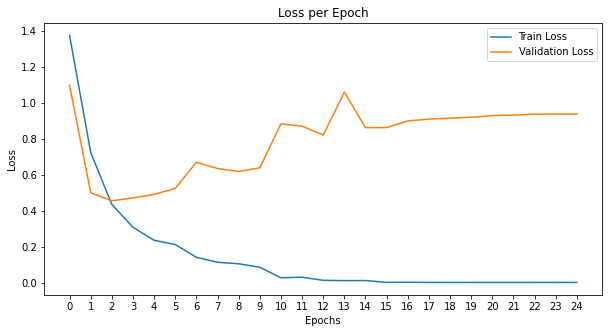

In [141]:
# Loss 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss per Epoch")
plt.xticks(range(len(train_losses)))  
plt.show()

In [142]:
filepath_test = os.getenv('HOME')+'/aiffel/dktc/data/test.json'

test = pd.read_json(filepath_test)

test.head().T

,text
t_000,아가씨 담배한갑주소 네 4500원입니다 어 네 지갑어디갔지 에이 버스에서 잃어버렸나...
t_001,우리팀에서 다른팀으로 갈 사람 없나? 그럼 영지씨가 가는건 어때? 네? 제가요? ...
t_002,너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 ...
t_003,이거 들어바 와 이 노래 진짜 좋다 그치 요즘 이 것만 들어 진짜 너무 좋다 내가 ...
t_004,아무튼 앞으로 니가 내 와이파이야. .응 와이파이 온. 켰어. 반말? 주인님이라고도...
...,...
t_495,미나씨 휴가 결제 올리기 전에 저랑 상의하라고 말한거 기억해요? 네 합니다. 보고서...
t_496,교수님 제 논문에 제 이름이 없나요? 아 무슨 논문말이야? 지난 번 냈던 논문이...
t_497,야 너 네 저요? 그래 너 왜요 돈좀 줘봐 돈 없어요 돈이 왜 없어 지갑은 폼이...
t_498,야 너 빨리 안 뛰어와? 너 이 환자 제대로 봤어 안 봤어 어제 저녁부터 계속 보다...


In [143]:
# 각 열에 있는 'text' 데이터를 추출하여 하나의 리스트로 만듭니다.
test_list = []

for column in test.columns:
    conversation = test[column]['text']
    test_list.append([conversation])  # 각 대화를 리스트에 추가

# 텍스트 클렌징 함수 (train에서 사용한 것과 동일하게 적용)
def clean_text(text):
    text = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z\s]", "", text)
    text = re.sub(r"\n", " ", text)
    return text

# 전처리 적용
test_list = [[clean_text(conversation[0])] for conversation in test_list]

# 토큰화 및 데이터셋 변환 (BERTDataset 클래스 및 토크나이저는 이미 정의되어 있다고 가정)
data_test = BERTDataset(test_list, 0, None, tok, max_len, True, False)

# 테스트 데이터 로더 생성
test_dataloader = DataLoader(data_test, batch_size=batch_size, num_workers=4)

In [144]:
# 모델 예측
model.eval()
predictions = []

with torch.no_grad():
    for batch_id, (token_ids, valid_length, segment_ids) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        
        # 모델 예측
        out = model(token_ids, segment_ids)
        pred = torch.argmax(out, dim=1).cpu().numpy()  # 가장 높은 확률의 클래스를 예측
        predictions.extend(pred)

# 숫자 레이블을 클래스명으로 변환하는 매핑
label_mapping = {
    0: "0",
    1: "1",
    2: "2",
    3: "3",
    4: "4"
}

# 예측된 숫자 레이블을 클래스명으로 변환
predicted_classes = [label_mapping[pred] for pred in predictions]

/tmp/ipykernel_31/3595121026.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids) in enumerate(tqdm_notebook(test_dataloader)):


  0%|          | 0/16 [00:00<?, ?it/s]

In [145]:
filepath_sub = os.getenv('HOME')+'/aiffel/dktc/data/submission.csv'

sub = pd.read_csv(filepath_sub)

sub.head()

,file_name,class
0,t_000,NaN
1,t_001,NaN
2,t_002,NaN
3,t_004,NaN
4,t_005,NaN


In [146]:
# 예측 결과를 DataFrame으로 변환
submission = pd.DataFrame({
    'idx': test.columns,  # 각 대화에 해당하는 열 이름
    'target': predicted_classes  # 예측된 클래스명
})

In [147]:
# 제출 파일로 저장
submission.to_csv('./LJ3.csv', index=False)